In [265]:
import pandas as pd
import numpy as np
import sqlalchemy
import ast
from itertools import chain
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter

In [267]:
plt.style.use("seaborn-colorblind")

# Data Preparation

In [6]:
clustering_df = pd.read_csv("data/track_clustering.csv", usecols=["track_id", "cluster"]).set_index("track_id")
clustering_df = clustering_df[clustering_df["cluster"] != -1]
clustering_df.head()

,cluster
track_id,
4868,1
572665,1
2897,1
15100,1
7112,1


In [10]:
beyms = pd.read_csv("data/beyms.csv")["user_id"].tolist()

In [11]:
clustered_tracks = clustering_df.index.unique().tolist()

# Calculate User-to-Cluster weights

In [7]:
db_options_df = pd.read_csv("db_credentials.txt", sep="=", header=None)
db_options_df.columns = ["variable", "value"]
db_options_df = db_options_df.apply(lambda col: col.str.strip())
db_options_df.set_index("variable", inplace=True)
db_options = db_options_df["value"].to_dict()
db_options

{'DB_PATH': '@localhost:3306/music_recommender_db',
 'DB_USERNAME': 'root',
 'DB_PW': '1234'}

In [9]:
connection = sqlalchemy.create_engine('mysql+pymysql://' + db_options["DB_USERNAME"] + ":" + db_options["DB_PW"] + db_options["DB_PATH"])

In [80]:
events_df = pd.read_sql(con=connection, sql="SELECT user_id, artist_id, track_id FROM events WHERE user_id IN " + str(tuple(beyms)) + " AND track_id IN " + str(tuple(clustered_tracks)))
events_df.head()

,user_id,artist_id,track_id
0,31435741,21,53
1,31435741,21,53
2,31435741,21,53
3,31435741,21,53
4,31435741,21,53


In [87]:
events_to_cluster_df = events_df.merge(clustering_df, left_on="track_id", right_index=True)
events_to_cluster_df.head()

,user_id,artist_id,track_id,cluster
0,31435741,21,53,1
1,31435741,21,53,1
2,31435741,21,53,1
3,31435741,21,53,1
4,31435741,21,53,1


In [88]:
weights_df = events_to_cluster_df.groupby(["user_id", "cluster"]).size() / events_to_cluster_df.groupby("user_id").size()
weights_df = weights_df.reset_index()
weights_df.columns = ["user_id", "cluster", "weight"]
weights_df = weights_df.pivot(index="user_id", columns="cluster", values="weight").fillna(0)
weights_df.head()

cluster,0,1,2,3
user_id,,,,
1049656,0.064476,0.295702,0.369318,0.270504
1055118,0.051454,0.940716,0.001119,0.006711
1056935,0.105074,0.711047,0.051457,0.132422
1070023,0.028662,0.816348,0.019108,0.135881
1072752,0.294695,0.431565,0.105435,0.168304


# Calculate IDF-score of Track Clusters

In [217]:
cluster_idf_scores = np.log10(len(clustering_df) / clustering_df.groupby("cluster").size())
cluster_idf_scores

cluster
0    1.070692
1    0.187658
2    1.272729
3    0.672623
dtype: float64

# Assign Users to Track Clusters

In [218]:
user_groups = []
for user_id, weights in weights_df.iterrows():
    favorite_track_cluster = (weights * cluster_idf_scores).idxmax()
    user_groups.append((user_id, favorite_track_cluster))
user_groups_df = pd.DataFrame(user_groups, columns=["user_id", "user group"]).set_index("user_id")
user_groups_df.head()

,user group
user_id,
1049656,2
1055118,1
1056935,1
1070023,1
1072752,0


In [219]:
U1 = user_groups_df[user_groups_df["user group"] == 0].index.tolist()
U2 = user_groups_df[user_groups_df["user group"] == 1].index.tolist()
U3 = user_groups_df[user_groups_df["user group"] == 2].index.tolist()
U4 = user_groups_df[user_groups_df["user group"] == 3].index.tolist()

# Basic Statistics of User Groups

In [220]:
n_artists_U1 = events_df[events_df["user_id"].isin(U1)]["artist_id"].nunique()
n_artists_U2 = events_df[events_df["user_id"].isin(U2)]["artist_id"].nunique()
n_artists_U3 = events_df[events_df["user_id"].isin(U3)]["artist_id"].nunique()
n_artists_U4 = events_df[events_df["user_id"].isin(U4)]["artist_id"].nunique()

In [221]:
n_tracks_U1 = events_df[events_df["user_id"].isin(U1)]["track_id"].nunique()
n_tracks_U2 = events_df[events_df["user_id"].isin(U2)]["track_id"].nunique()
n_tracks_U3 = events_df[events_df["user_id"].isin(U3)]["track_id"].nunique()
n_tracks_U4 = events_df[events_df["user_id"].isin(U4)]["track_id"].nunique()

In [222]:
n_LEs_U1 = len(events_df[events_df["user_id"].isin(U1)])
n_LEs_U2 = len(events_df[events_df["user_id"].isin(U2)])
n_LEs_U3 = len(events_df[events_df["user_id"].isin(U3)])
n_LEs_U4 = len(events_df[events_df["user_id"].isin(U4)])

In [223]:
genres_in_clusters_df = pd.read_csv("data/genre_annotations.csv").merge(clustering_df, left_on="track_id", right_index=True)
genres_in_clusters_df["genres"] = genres_in_clusters_df["genres"].apply(ast.literal_eval)

n_genres_U1 = genres_in_clusters_df.groupby("cluster")["genres"].apply(chain.from_iterable).apply(set).apply(len)[0]
n_genres_U2 = genres_in_clusters_df.groupby("cluster")["genres"].apply(chain.from_iterable).apply(set).apply(len)[1]
n_genres_U3 = genres_in_clusters_df.groupby("cluster")["genres"].apply(chain.from_iterable).apply(set).apply(len)[2]
n_genres_U4 = genres_in_clusters_df.groupby("cluster")["genres"].apply(chain.from_iterable).apply(set).apply(len)[3]

In [224]:
avg_LEs_U1 = events_df[events_df["user_id"].isin(U1)].groupby("user_id").size().mean()
avg_LEs_U2 = events_df[events_df["user_id"].isin(U2)].groupby("user_id").size().mean()
avg_LEs_U3 = events_df[events_df["user_id"].isin(U3)].groupby("user_id").size().mean()
avg_LEs_U4 = events_df[events_df["user_id"].isin(U4)].groupby("user_id").size().mean()

In [225]:
avg_tracks_U1 = events_df[events_df["user_id"].isin(U1)].groupby("user_id")["track_id"].nunique().mean()
avg_tracks_U2 = events_df[events_df["user_id"].isin(U2)].groupby("user_id")["track_id"].nunique().mean()
avg_tracks_U3 = events_df[events_df["user_id"].isin(U3)].groupby("user_id")["track_id"].nunique().mean()
avg_tracks_U4 = events_df[events_df["user_id"].isin(U4)].groupby("user_id")["track_id"].nunique().mean()

In [226]:
users_df = pd.read_csv("data/LFM-1b_users.txt", sep="\t")
users_df = users_df[users_df["age"] != -1]
avg_age_U1 = users_df[users_df["user_id"].isin(U1)]["age"].mean()
avg_age_U2 = users_df[users_df["user_id"].isin(U2)]["age"].mean()
avg_age_U3 = users_df[users_df["user_id"].isin(U3)]["age"].mean()
avg_age_U4 = users_df[users_df["user_id"].isin(U4)]["age"].mean()
sd_age_U1 = users_df[users_df["user_id"].isin(U1)]["age"].std()
sd_age_U2 = users_df[users_df["user_id"].isin(U2)]["age"].std()
sd_age_U3 = users_df[users_df["user_id"].isin(U3)]["age"].std()
sd_age_U4 = users_df[users_df["user_id"].isin(U4)]["age"].std()

In [227]:
print("[Users] U_folk: %d, U_hard: %d, U_ambi: %d, U_elec: %d" % (len(U1), len(U2), len(U3), len(U4)))
print("[Artists]  U_folk: %d, U_hard: %d, U_ambi: %d, U_elec: %d"% (n_artists_U1, n_artists_U2, n_artists_U3, n_artists_U4))
print("[Tracks]  U_folk: %d, U_hard: %d, U_ambi: %d, U_elec: %d" % (n_tracks_U1, n_tracks_U2, n_tracks_U3, n_tracks_U4))
print("[LEs] U_folk: %d, U_hard: %d, U_ambi: %d, U_elec: %d" % (n_LEs_U1, n_LEs_U2, n_LEs_U3, n_LEs_U4))
print("[Genres] U_folk: %d, U_hard: %d, U_ambi: %d, U_elec: %d" % (n_genres_U1, n_genres_U2, n_genres_U3, n_genres_U4))
print("[Avg. LEs per user] U_folk: %.3f, U_hard: %.3f, U_ambi: %.3f, U_elec: %.3f" % (avg_LEs_U1, avg_LEs_U2, avg_LEs_U3, avg_LEs_U4))
print("[Avg. Tracks per user] U_folk: %.3f, U_hard: %.3f, U_ambi: %.3f, U_elec: %.3f" % (avg_tracks_U1, avg_tracks_U2, avg_tracks_U3, avg_tracks_U4))
print("[Avg. Age (Std)] U_folk: %.3f (%.3f), U_hard: %.3f (%.3f), U_ambi: %.3f (%.3f), U_elec: %.3f (%.3f)" % (avg_age_U1, sd_age_U1, avg_age_U2, sd_age_U2, avg_age_U3, sd_age_U3, avg_age_U4, sd_age_U4))

[Users] U_folk: 369, U_hard: 919, U_ambi: 143, U_elec: 642
[Artists]  U_folk: 9559, U_hard: 11966, U_ambi: 6869, U_elec: 11814
[Tracks]  U_folk: 72663, U_hard: 107952, U_ambi: 39649, U_elec: 105907
[LEs] U_folk: 702635, U_hard: 2150246, U_ambi: 224327, U_elec: 1416354
[Genres] U_folk: 811, U_hard: 1274, U_ambi: 695, U_elec: 1005
[Avg. LEs per user] U_folk: 1904.160, U_hard: 2339.767, U_ambi: 1568.720, U_elec: 2206.159
[Avg. Tracks per user] U_folk: 549.650, U_hard: 557.470, U_ambi: 473.308, U_elec: 670.402
[Avg. Age (Std)] U_folk: 27.599 (10.369), U_hard: 23.867 (8.912), U_ambi: 29.571 (14.138), U_elec: 24.639 (7.886)


# Radar plot of a Track Cluster's contribution

In [228]:
weighted_weights = []
for user_id, weights in weights_df.iterrows():
    data_dict = (weights * cluster_idf_scores).to_dict()
    data_dict["user_id"] = user_id
    weighted_weights.append(data_dict)
weighted_weights_df = pd.DataFrame.from_dict(weighted_weights, orient="columns").set_index("user_id")
weighted_weights_df.head()

,0,1,2,3
user_id,,,,
1049656,0.069034,0.055491,0.470042,0.181947
1055118,0.055092,0.176533,0.001424,0.004514
1056935,0.112502,0.133433,0.065491,0.089070
1070023,0.030689,0.153194,0.024320,0.091397
1072752,0.315528,0.080987,0.134191,0.113205


In [236]:
avg_weights_df = weighted_weights_df.merge(user_groups_df, left_index=True, right_index=True).groupby("user group").mean()
avg_weights_df

,0,1,2,3
user group,,,,
0,0.263447,0.115818,0.064586,0.057860
1,0.048659,0.160083,0.018255,0.058622
2,0.107651,0.078281,0.341494,0.143935
3,0.042252,0.100099,0.070363,0.250107


In [284]:
angles = np.linspace(0, 2*np.pi, 4, endpoint=False)
angles = np.concatenate((angles, [angles[0]]))
sns.set(font_scale=1.6)
fig = plt.figure()
ax = fig.add_subplot(111, polar=True)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
colors = ["#0072B2", "#009E73", "#D55E00", "#CC79A7"]
markers = ["o", "^", "s", "D"]
listeners = [r"$U_{folk}$", r"$U_{hard}$", r"$U_{ambi}$", r"$U_{elec}$"]
linestyles = ['-', '--', '-.', ':']
iteration_order = [2, 3, 0, 1]
for c in iteration_order:
    weights = avg_weights_df.loc[c]
    means = np.concatenate((weights.values, [weights.values[0]]))
    ax.plot(angles, means, 'o-', linewidth=2, label=listeners[c], color=colors[c], marker=markers[c])
    ax.set_thetagrids(angles * 180/np.pi, [r"$C_{folk}$", r"$C_{hard}$", r"$C_{ambi}$", r"$C_{elec}$"])
    ax.grid(True)
    ax.tick_params(pad=20)
    plt.ylim(0, 0.4)

handles, labels = ax.get_legend_handles_labels()
resorted = [(labels[iteration_order.index(c)], handles[ iteration_order.index(c)]) for c in range(4)]
labels, handles = zip(*resorted)
plt.legend(handles, labels)

# Correlation of Track Clusters over Listening Events

(array([0.5, 1.5, 2.5, 3.5]), <a list of 4 Text yticklabel objects>)

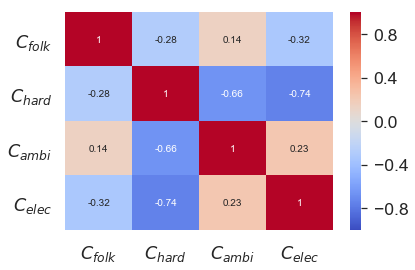

In [292]:
ax = sns.heatmap(weights_df.corr(), annot=True, vmax=1, vmin=-1, cmap="coolwarm")
plt.xlabel("")
plt.ylabel("")
ax.set_xticklabels([r"$C_{folk}$", r"$C_{hard}$", r"$C_{ambi}$", r"$C_{elec}$"])
ax.set_yticklabels([r"$C_{folk}$", r"$C_{hard}$", r"$C_{ambi}$", r"$C_{elec}$"])
plt.yticks(rotation=0)